In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from typing import List, Tuple, Dict
import csv    
import matplotlib.pyplot as plt

In [4]:
HEAD_SIZE = 16
MAX_LEN = 50
device = "mps"

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, head_size, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.W_q = nn.Linear(hidden_size, num_heads * head_size)
        self.W_k = nn.Linear(hidden_size, num_heads * head_size)
        self.W_v = nn.Linear(hidden_size, num_heads * head_size)
        self.W_o = nn.Linear(num_heads * head_size, hidden_size)

    def forward(self, x, mask=None):
        batch_size, seq_len, hidden_size = x.size()
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_size ** 0.5)
        if mask is not None:
            # Ensure mask is boolean and matches the attention scores shape
            mask = mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(~mask, float('-inf'))
        attention_weights = torch.softmax(scores, dim=-1)
        context = torch.matmul(attention_weights, V).transpose(1, 2).contiguous()
        context = context.view(batch_size, seq_len, -1)
        return self.W_o(context)

class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, head_size, num_heads):
        super().__init__()
        self.attention = MultiHeadAttention(hidden_size, head_size, num_heads)
        self.layernorm1 = nn.LayerNorm(hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, 4 * hidden_size),
            nn.ReLU(),
            nn.Linear(4 * hidden_size, hidden_size)
        )
        self.layernorm2 = nn.LayerNorm(hidden_size)

    def forward(self, x, mask=None):
        attn_output = self.attention(x, mask)
        x = self.layernorm1(x + attn_output)
        mlp_output = self.mlp(x)
        return self.layernorm2(x + mlp_output)

class BalancedParenthesesModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, max_len, num_layers, num_heads):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.positional_encodings = nn.Parameter(torch.zeros(1, max_len, hidden_size))
        self.layers = nn.ModuleList([
            TransformerBlock(hidden_size, HEAD_SIZE, num_heads)
            for _ in range(num_layers)
        ])
        self.layernorm_final = nn.LayerNorm(hidden_size)
        self.unembedding = nn.Linear(hidden_size, 2)
        
        # Store intermediate states during forward pass
        self.token_states = None

    def forward(self, x, mask=None, return_states=False):
        seq_len = x.size(1)
        
        # Embedding with positional encodings
        x = self.embedding(x) + self.positional_encodings[:, :seq_len, :]
        
        # Pass through transformer layers
        for layer in self.layers:
            x = layer(x, mask)
        
        # Final layer normalization
        x = self.layernorm_final(x)
        
        # Compute logits
        logits = self.unembedding(x[:, 0, :])
        
        # Store token states if requested
        if return_states:
            return logits, x.detach()
        
        return logits

class ParenthesisDataset:
    def __init__(self, num_samples: int = 10000):
        self.brackets = ['()', '[]', '{}']
        self.samples, self.labels = self.generate_dataset(num_samples)
        self.test_samples, self.test_labels = self.generate_dataset(num_samples // 10)
        self.stack_top_samples, self.stack_top_labels = self.generate_stack_top_dataset()
    
    def generate_balanced_string(self, max_length: int = 80) -> Tuple[str, List[str]]:
        """Generate a balanced parenthesis string."""
        possible_brackets = self.brackets
        length = random.randint(2, max_length)
        stack = []
        result = []
        stack_top_sequence = []
        
        while len(result) < length:
            if not stack or random.random() < 0.5:
                # Push an opening bracket
                bracket = random.choice(possible_brackets)[0]
                result.append(bracket)
                stack.append(bracket)
                stack_top_sequence.append(bracket)
            else:
                # Pop a closing bracket
                opening = stack.pop()
                closing = {'(': ')', '[': ']', '{': '}'}[opening]
                result.append(closing)
                stack_top_sequence.append(closing if not stack else stack[-1])
        
        # Ensure all brackets are closed
        while stack:
            opening = stack.pop()
            closing = {'(': ')', '[': ']', '{': '}'}[opening]
            result.append(closing)
            stack_top_sequence.append(closing if not stack else stack[-1])
        
        return ''.join(result), stack_top_sequence
    
    def generate_unbalanced_string(self, max_length: int = 80) -> Tuple[str, List[str]]:
        """Generate an unbalanced parenthesis string."""
        if random.random() < 0.5:
            # Mismatched brackets
            base_balanced, base_top_sequence = self.generate_balanced_string(max_length)
            mis_index = random.randint(0, len(base_balanced) - 1)
            base_list = list(base_balanced)
            base_list[mis_index] = random.choice(['(', ')', '[', ']', '{', '}'])
            return ''.join(base_list), base_top_sequence
        else:
            # Unbalanced brackets
            base, base_top_sequence = self.generate_balanced_string(max_length)
            base_list = list(base)
            # Remove some closing or opening brackets
            remove_count = random.randint(1, len(base_list) // 2)
            for _ in range(remove_count):
                remove_index = random.randint(0, len(base_list) - 1)
                base_list.pop(remove_index)
            return ''.join(base_list), base_top_sequence
    
    def generate_dataset(self, num_samples: int) -> Tuple[List[str], List[int]]:
        """Generate balanced and unbalanced dataset."""
        samples = []
        labels = []
        
        for _ in range(num_samples // 2):
            samples.append(self.generate_balanced_string()[0])
            labels.append(1)  # Balanced
            
            samples.append(self.generate_unbalanced_string()[0])
            labels.append(0)  # Unbalanced

        dataset = list(zip(samples, labels))
        random.shuffle(dataset)
        
        with open('./dataset.json', 'w') as f:
            json.dump(dataset, f)
        
        return samples, labels
    
    def generate_stack_top_dataset(self, num_samples: int = 5000):
        """Generate dataset for stack top probing."""
        samples = []
        labels = []
        bracket_to_index = {bracket: idx for idx, bracket in enumerate(['(', '[', '{'])}
        
        for _ in range(num_samples):
            # Generate a balanced string
            _, stack_top_sequence = self.generate_balanced_string()
            
            # Create sample with stack top sequence
            valid_top_brackets = [b for b in stack_top_sequence if b in bracket_to_index]
            if valid_top_brackets:
                samples.append(stack_top_sequence)
                labels.append(bracket_to_index[valid_top_brackets[-1]])
        
        return samples, labels

class ParenthesisTokenizer:
    def __init__(self):
        self.special_tokens = {
            'PAD': 0,
            'START': 1,
            'END': 2
        }
        self.token_to_index = {
            '(': 3, ')': 4,
            '[': 5, ']': 6,
            '{': 7, '}': 8
        }
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}
        self.vocab_size = len(self.special_tokens) + len(self.token_to_index)
    
    def encode(self, text: str, max_length: int = MAX_LEN) -> List[int]:
        """Tokenize a string with START and END tokens and padding."""
        tokens = [self.special_tokens['START']]
        tokens.extend([self.token_to_index[char] for char in text])
        tokens.append(self.special_tokens['END'])
        
        # Pad or truncate
        if len(tokens) > max_length:
            tokens = tokens[:max_length]
        else:
            tokens += [self.special_tokens['PAD']] * (max_length - len(tokens))
        
        return tokens
    
    def create_mask(self, tokens: List[int]) -> torch.Tensor:
        """Create an attention mask that is False for pad tokens."""
        return torch.tensor([token != self.special_tokens['PAD'] for token in tokens], dtype=torch.bool)


In [39]:

class StackTopProbeClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # 3 types of opening brackets
        )
    
    def forward(self, x):
        return self.classifier(x)

In [44]:
def train_balanced_parentheses_model(dataset, tokenizer):
    # Hyperparameters
    hidden_size = 128
    num_layers = 3
    num_heads = 4
    batch_size = 32
    epochs = 20

    acc = []
    losses = []
    
    # Initialize models
    model = BalancedParenthesesModel(
        vocab_size=9,
        hidden_size=hidden_size, 
        max_len=MAX_LEN, 
        num_layers=num_layers,
        num_heads=num_heads
    ).to(device)
    
    # Training setup
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Store final token states
    final_token_states = None
    
    for epoch in range(epochs):
        total_loss = 0
        
        # Shuffle dataset
        indices = list(range(len(dataset.samples)))
        random.shuffle(indices)
        
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            
            # Prepare batch
            batch_samples = [dataset.samples[j] for j in batch_indices]
            batch_labels = [dataset.labels[j] for j in batch_indices]
            
            # Tokenize and create tensors
            batch_tokens = torch.tensor([tokenizer.encode(sample) for sample in batch_samples]).to(device)
            batch_masks = torch.stack([tokenizer.create_mask(tokenizer.encode(sample)) for sample in batch_samples]).to(device)
            batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass with token states
            logits, token_states = model(batch_tokens, batch_masks, return_states=True)
            
            # Compute loss
            loss = criterion(logits, batch_labels)
    
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())

            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(indices)}")
        
        # Evaluate the model on the test set after each epoch
        model.eval()
        with torch.no_grad():
            test_samples = dataset.test_samples
            test_labels = dataset.test_labels

            # Tokenize and create tensors
            test_tokens = torch.tensor([tokenizer.encode(sample) for sample in test_samples]).to(device)
            test_masks = torch.stack([tokenizer.create_mask(tokenizer.encode(sample)) for sample in test_samples]).to(device)
            test_labels = torch.tensor(test_labels, dtype=torch.long).to(device)

            # Forward pass
            logits = model(test_tokens, test_masks)
            predictions = logits.argmax(dim=-1)
            accuracy = (predictions == test_labels).float().mean().item()
            acc.append(accuracy)
            print(f"Test Accuracy: {accuracy}")
        
        # Store the last batch's token states
        final_token_states = token_states
        
        # Switch back to training mode
        model.train()

    return model, final_token_states, acc, losses

def train_stack_top_probe(model, dataset, token_states, tokenizer):
    # Stack top probe classifier
    probe_classifier = StackTopProbeClassifier(input_size=token_states.shape[-1]).to(device)
    optimizer = optim.Adam(probe_classifier.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    epochs = 30
    batch_size = 32

    acc = []
    losses = []
    
    # Prepare stack top dataset
    stack_top_samples = dataset.stack_top_samples
    stack_top_labels = dataset.stack_top_labels
    
    for epoch in range(epochs):
        total_loss = 0
        
        # Shuffle dataset
        indices = list(range(len(stack_top_samples)))
        random.shuffle(indices)
        
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            
            # Prepare batch
            batch_samples = [stack_top_samples[j] for j in batch_indices]
            batch_labels = torch.tensor([stack_top_labels[j] for j in batch_indices]).to(device)
            
            # Tokenize samples
            batch_tokens = torch.tensor([tokenizer.encode(sample) for sample in [''.join(sample) for sample in batch_samples]]).to(device)
            batch_masks = torch.stack([tokenizer.create_mask(tokenizer.encode(sample)) for sample in [''.join(sample) for sample in batch_samples]]).to(device)
            
            # Get token states for these samples
            with torch.no_grad():
                _, batch_token_states = model(batch_tokens, batch_masks, return_states=True)
            
            # Use the first token state (CLS token)
            batch_input = batch_token_states[:, 0, :]
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            logits = probe_classifier(batch_input)
            loss = criterion(logits, batch_labels)
            losses.append(loss.item())
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        print(f"Stack Top Probe Epoch {epoch+1}, Loss: {total_loss/len(indices)}")
        
        # Evaluate the model on the test set after each epoch
        probe_classifier.eval()
        with torch.no_grad():
            # Tokenize and create tensors
            stack_top_tokens = torch.tensor([tokenizer.encode(sample) for sample in [''.join(sample) for sample in stack_top_samples]]).to(device)
            stack_top_masks = torch.stack([tokenizer.create_mask(tokenizer.encode(sample)) for sample in [''.join(sample) for sample in stack_top_samples]]).to(device)
            stack_top_labels = torch.tensor(stack_top_labels, dtype=torch.long).to(device)

            # Get token states for these samples
            _, stack_top_token_states = model(stack_top_tokens, stack_top_masks, return_states=True)

            # Use the first token state (CLS token)
            stack_top_input = stack_top_token_states[:, 0, :]

            # Forward pass
            stack_top_logits = probe_classifier(stack_top_input)
            stack_top_predictions = stack_top_logits.argmax(dim=-1)
            stack_top_accuracy = (stack_top_predictions == stack_top_labels).float().mean().item()
            acc.append(stack_top_accuracy)
            print(f"Stack Top Probe Test Accuracy: {stack_top_accuracy}")
        
        # Switch back to training mode
        probe_classifier.train()
    
    return probe_classifier, acc, losses

In [ ]:
model_losses = []
model_accuracies = []
probe_losses = []
probe_acc = []
untrained_probe_loss = []
untrained_probe_acc = []

# Create Dataset
dataset = ParenthesisDataset(num_samples=1000)

# Create Tokenizer
tokenizer = ParenthesisTokenizer()

# Train Balanced Parentheses Model
model, token_states, model_acc, model_losses = train_balanced_parentheses_model(dataset, tokenizer)
model.to(device)
token_states = token_states.to(device)
model_acc = 100*np.array(model_acc)



In [45]:

# Train Stack Top Probe Classifier
stack_top_probe, probe_acc, prob_losses = train_stack_top_probe(model, dataset, token_states, tokenizer)

probe_acc = 100*np.array(probe_acc)



Stack Top Probe Epoch 1, Loss: 0.026829742932319642
Stack Top Probe Test Accuracy: 0.6935999989509583
Stack Top Probe Epoch 2, Loss: 0.020221102130413057


/var/folders/1c/pssfr1c910ncsn52rc0ypzzc0000gn/T/ipykernel_85825/3652888249.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stack_top_labels = torch.tensor(stack_top_labels, dtype=torch.long).to(device)


Stack Top Probe Test Accuracy: 0.7062000036239624
Stack Top Probe Epoch 3, Loss: 0.018718792235851288
Stack Top Probe Test Accuracy: 0.7045999765396118
Stack Top Probe Epoch 4, Loss: 0.01773559513092041
Stack Top Probe Test Accuracy: 0.7217999696731567
Stack Top Probe Epoch 5, Loss: 0.01735240820646286
Stack Top Probe Test Accuracy: 0.7267999649047852
Stack Top Probe Epoch 6, Loss: 0.016925843277573585
Stack Top Probe Test Accuracy: 0.7257999777793884
Stack Top Probe Epoch 7, Loss: 0.016628089624643325
Stack Top Probe Test Accuracy: 0.7343999743461609
Stack Top Probe Epoch 8, Loss: 0.01667372462749481
Stack Top Probe Test Accuracy: 0.7247999906539917
Stack Top Probe Epoch 9, Loss: 0.01632155027985573
Stack Top Probe Test Accuracy: 0.736799955368042
Stack Top Probe Epoch 10, Loss: 0.016167136988043784
Stack Top Probe Test Accuracy: 0.7253999710083008
Stack Top Probe Epoch 11, Loss: 0.016005437478423118
Stack Top Probe Test Accuracy: 0.72079998254776
Stack Top Probe Epoch 12, Loss: 0.016

In [46]:


untrained_model = BalancedParenthesesModel(
    vocab_size=9,
    hidden_size=128, 
    max_len=MAX_LEN, 
    num_layers=3,
    num_heads=4
)

untrained_model.to(device)

untrained_probe, untrained_probe_acc, untrained_probe_loss = train_stack_top_probe(untrained_model, dataset, token_states, tokenizer)

Stack Top Probe Epoch 1, Loss: 0.02731478523015976
Stack Top Probe Test Accuracy: 0.6425999999046326
Stack Top Probe Epoch 2, Loss: 0.022528628098964693


/var/folders/1c/pssfr1c910ncsn52rc0ypzzc0000gn/T/ipykernel_85825/3652888249.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stack_top_labels = torch.tensor(stack_top_labels, dtype=torch.long).to(device)


Stack Top Probe Test Accuracy: 0.6714000105857849
Stack Top Probe Epoch 3, Loss: 0.021132242304086685
Stack Top Probe Test Accuracy: 0.7081999778747559
Stack Top Probe Epoch 4, Loss: 0.020013470697402953
Stack Top Probe Test Accuracy: 0.7181999683380127
Stack Top Probe Epoch 5, Loss: 0.019435514718294144
Stack Top Probe Test Accuracy: 0.738599956035614
Stack Top Probe Epoch 6, Loss: 0.018864345383644104
Stack Top Probe Test Accuracy: 0.7445999979972839
Stack Top Probe Epoch 7, Loss: 0.018260891044139863
Stack Top Probe Test Accuracy: 0.7307999730110168
Stack Top Probe Epoch 8, Loss: 0.01788857460618019
Stack Top Probe Test Accuracy: 0.7569999694824219
Stack Top Probe Epoch 9, Loss: 0.01721929633617401
Stack Top Probe Test Accuracy: 0.745199978351593
Stack Top Probe Epoch 10, Loss: 0.01710204139351845
Stack Top Probe Test Accuracy: 0.7572000026702881
Stack Top Probe Epoch 11, Loss: 0.016528219693899154
Stack Top Probe Test Accuracy: 0.7545999884605408
Stack Top Probe Epoch 12, Loss: 0.0

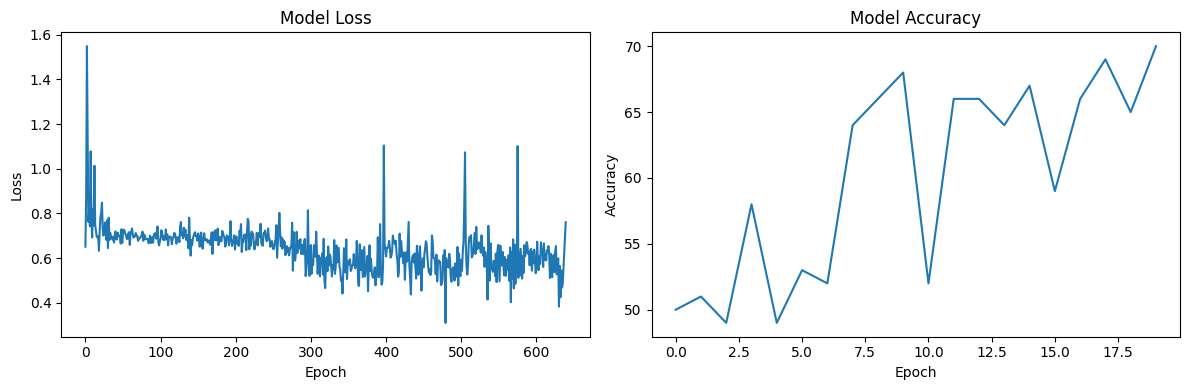

In [47]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_losses)
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(model_acc)
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [48]:
probe_losses

[]

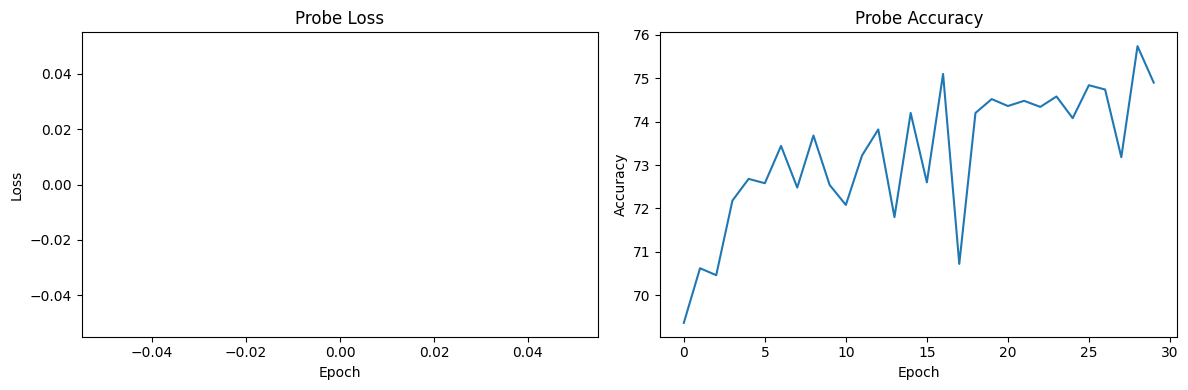

In [49]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(probe_losses)
plt.title("Probe Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(probe_acc)
plt.title("Probe Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [50]:
untrained_probe_acc = np.array(untrained_probe_acc)*100

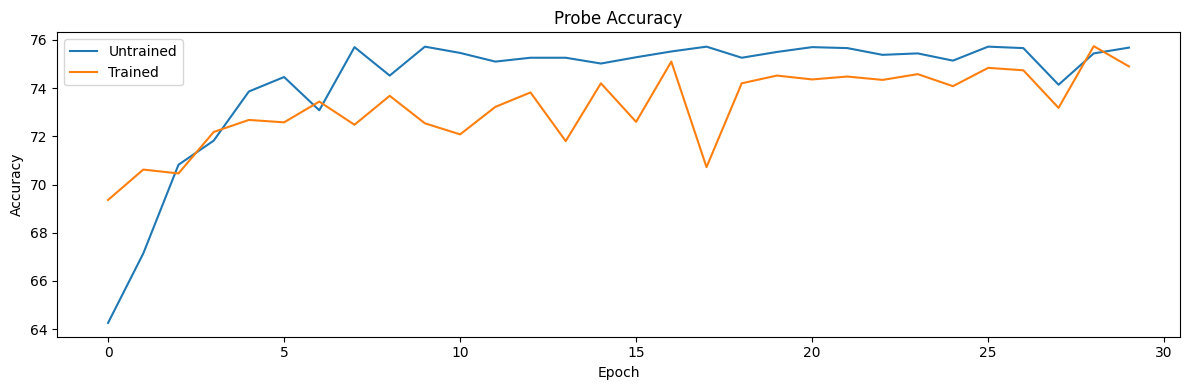

In [51]:
plt.figure(figsize=(12, 4))
plt.plot(untrained_probe_acc)
plt.title("Untrained Probe Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(probe_acc)
plt.title("Probe Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Untrained", "Trained"])
plt.tight_layout()
plt.show()

In [10]:
data_obj = ParenthesisDataset(num_samples=8000)

In [7]:
import json